In [1]:
import pandas as pd
from global_land_mask import globe

In [2]:
ndf = pd.read_csv('../data/2_blank_da_data.csv')
ndf['index'] = ndf.index

ndf.head()

,LAT,LON,LAT_25,LON_25,LAT_5,LON_5,knutson_precip,updated_precip,knutson_temp,updated_temp,population,diff_temp,diff_precip,index
0,-88.75,-178.75,-88.75,-178.75,-87.5,-177.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0
1,-88.75,-176.25,-88.75,-176.25,-87.5,-177.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1
2,-88.75,-173.75,-88.75,-173.75,-87.5,-172.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2
3,-88.75,-171.25,-88.75,-171.25,-87.5,-172.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3
4,-88.75,-168.75,-88.75,-168.75,-87.5,-167.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4


In [3]:
relevance_preds = pd.read_csv('../data/1_document_relevance.csv')
df_ndf = pd.read_csv(f'../data/study_gridcell_2.5.csv')
print(df_ndf.shape)
#df_ndf = df_ndf[df_ndf.doc_id.isin(relevance_preds.loc[relevance_preds['0 - relevance - upper_pred']>=0.5,"id"])]
upper_ids = relevance_preds.loc[relevance_preds['0 - relevance - upper_pred']>=0.5,"id"]
mid_ids = relevance_preds.loc[relevance_preds['0 - relevance - mean_prediction']>=0.5,"id"]
lower_ids = relevance_preds.loc[relevance_preds['0 - relevance - lower_pred']>=0.5,"id"]


print(df_ndf.shape)
df_ndf = df_ndf.merge(df_ndf.groupby('doc_id').count().reset_index().rename(columns={"ndf_id":"gridcells"}))
df_ndf['weight'] = 1/df_ndf['gridcells']
print(df_ndf.shape)
df_ndf.head()

(5447194, 2)
(5447194, 2)
(5447194, 4)


,ndf_id,doc_id,gridcells,weight
0,7674.0,3323227.0,6,0.166667
1,6804.0,3323227.0,6,0.166667
2,6720.0,3323227.0,6,0.166667
3,7327.0,3323227.0,6,0.166667
4,7674.0,3323227.0,6,0.166667


In [4]:
if "all_study_prop" not in ndf.columns:
    for label, ids in [("all_study_prop", mid_ids),("all_study_prop_upper",upper_ids), ("all_study_prop_lower",lower_ids)]:
        ndf = ndf.merge(df_ndf[df_ndf['doc_id'].isin(ids)].groupby('ndf_id')['weight'].sum().to_frame().rename(columns={"weight":label}), left_on="index", right_on="ndf_id", how="left")
        ndf[label] = ndf[label].fillna(0) 
    
ndf.head()

,LAT,LON,LAT_25,LON_25,LAT_5,LON_5,knutson_precip,updated_precip,knutson_temp,updated_temp,population,diff_temp,diff_precip,index,all_study_prop,all_study_prop_upper,all_study_prop_lower
0,-88.75,-178.75,-88.75,-178.75,-87.5,-177.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,0.0,0.0,0.0
1,-88.75,-176.25,-88.75,-176.25,-87.5,-177.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1,0.0,1.0,0.0
2,-88.75,-173.75,-88.75,-173.75,-87.5,-172.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2,0.0,0.0,0.0
3,-88.75,-171.25,-88.75,-171.25,-87.5,-172.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3,0.0,0.0,0.0
4,-88.75,-168.75,-88.75,-168.75,-87.5,-167.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4,0.0,0.0,0.0


In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy
import numpy as np
import matplotlib as mpl


fig = plt.figure(dpi=150,figsize=(7.2,6.5))

gs = gridspec.GridSpec(4, 6, height_ratios=[.1, .25, 1, .25], bottom=.05, top=.95, wspace=.4, hspace=0.0)

ax = plt.subplot(gs[2, :], projection=ccrs.EqualEarth())

#ndf.loc[ndf['LON']>180,"LON"]-=360

n = np.array(ndf.all_study_prop_upper).reshape(len(ndf.LAT.unique()), len(ndf.LON.unique()))
vm = n.max()
n[n==0] = np.nan

bounds = np.array([0,1,5,10,50,100,500,vm])

X, Y = np.meshgrid(
    list(ndf.LON.unique())+[ndf.LON.max()+2.5],   
    list(ndf.LAT.unique())+[ndf.LAT.max()+2.5], 
)
X.shape

ax.coastlines(lw=0.1)
mesh = ax.pcolormesh(
    X, Y,
    n,
    norm = mpl.colors.BoundaryNorm(bounds,256),
    #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
    #cmap = "YlOrBr",
    cmap = "magma_r",
    #cmap=plt.cm.get_cmap('YlOrBr',12), 
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)
cbar = plt.colorbar(mesh, orientation="vertical", fraction=0.05, pad=0.05, ax=ax, shrink=0.5)

cbar.set_label("Weighted studies per grid cell", fontsize=6)
#cbar.ax.tick_params(labelsize=6)

In [6]:
ndf['WA'] = np.NaN
ndf.loc[
    (ndf['LAT']<-21.25) & (ndf['LAT']>-35.25) & 
    (ndf['LON']>115.75) & (ndf['LON']<135.75) & 
    (~abs(ndf['updated_temp'].isin([2,3]))),'WA'] = 1

In [7]:
ndf.head()

,LAT,LON,LAT_25,LON_25,LAT_5,LON_5,knutson_precip,updated_precip,knutson_temp,updated_temp,population,diff_temp,diff_precip,index,all_study_prop,all_study_prop_upper,all_study_prop_lower,WA
0,-88.75,-178.75,-88.75,-178.75,-87.5,-177.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,0.0,0.0,0.0,NaN
1,-88.75,-176.25,-88.75,-176.25,-87.5,-177.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1,0.0,1.0,0.0,NaN
2,-88.75,-173.75,-88.75,-173.75,-87.5,-172.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2,0.0,0.0,0.0,NaN
3,-88.75,-171.25,-88.75,-171.25,-87.5,-172.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3,0.0,0.0,0.0,NaN
4,-88.75,-168.75,-88.75,-168.75,-87.5,-167.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4,0.0,0.0,0.0,NaN


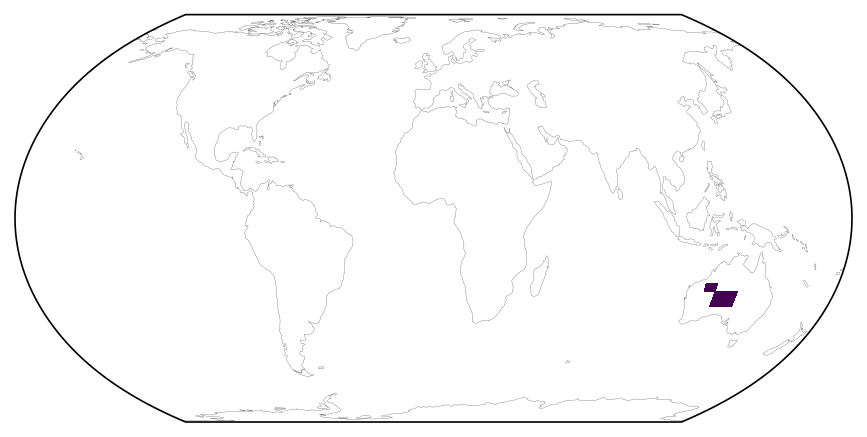

In [8]:
fig = plt.figure(dpi=150,figsize=(7.2,6.5))
ax = plt.subplot(projection=ccrs.EqualEarth())

#ndf.loc[ndf['LON']>180,"LON"]-=360


n = np.array(ndf.WA).reshape(len(ndf.LAT.unique()), len(ndf.LON.unique()))
vm = n.max()
#n[n==0] = np.nan


X, Y = np.meshgrid(
    list(ndf.LON.unique())+[ndf.LON.max()+2.5],   
    list(ndf.LAT.unique())+[ndf.LAT.max()+2.5], 
)
X.shape

ax.coastlines(lw=0.1)
mesh = ax.pcolormesh(
    X, Y,
    n,
    #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
    #cmap = "YlOrBr",
    #cmap=plt.cm.get_cmap('YlOrBr',12), 
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)

In [9]:
df_ndf[df_ndf['ndf_id'].isin(ndf[ndf['WA']==1].index)].sort_values('gridcells').head(1000).tail(500)

,ndf_id,doc_id,gridcells,weight
3507457,3581.0,3924837.0,17,0.058824
3507458,3725.0,3924837.0,17,0.058824
3506766,3724.0,3299471.0,17,0.058824
3506765,3580.0,3299471.0,17,0.058824
3506942,3580.0,209170.0,17,0.058824
...,...,...,...,...
3516596,3722.0,1378032.0,40,0.025000
3516595,3578.0,1378032.0,40,0.025000
3516590,3865.0,1378032.0,40,0.025000
3516671,3865.0,556236.0,40,0.025000


In [10]:
driver_df = pd.read_csv('../data/1_driver_predictions.csv')
driver_df.head()

,id,6 - Temperature - mean_prediction,6 - Temperature - std_prediction,6 - Temperature - lower_pred,6 - Temperature - upper_pred,6 - Precipitation - mean_prediction,6 - Precipitation - std_prediction,6 - Precipitation - lower_pred,6 - Precipitation - upper_pred,6 - Other - mean_prediction,6 - Other - std_prediction,6 - Other - lower_pred,6 - Other - upper_pred
0,1300115,0.599319,0.123371,0.475948,0.722689,0.039122,0.007976,0.031147,0.047098,0.438100,0.142500,0.295600,0.580600
1,626619,0.163634,0.046660,0.116974,0.210294,0.244802,0.041110,0.203692,0.285913,0.634133,0.103451,0.530682,0.737583
2,3910065,0.276482,0.167964,0.108517,0.444446,0.765776,0.082619,0.683157,0.848395,0.224603,0.095029,0.129574,0.319631
3,2317601,0.613144,0.223667,0.389477,0.836811,0.183233,0.014026,0.169207,0.197258,0.300958,0.181628,0.119329,0.482586
4,618304,0.867647,0.054082,0.813565,0.921728,0.036531,0.008577,0.027954,0.045109,0.137281,0.047012,0.090269,0.184293


In [11]:
if "precip_study_prop" not in ndf.columns:
    for var, driver in [("temp","Temperature"),("precip","Precipitation")]:
        for label, suffix in [(f"{var}_study_prop","mean_prediction"),(f"{var}_study_prop_upper","upper_pred"),(f"{var}_study_prop_lower","lower_pred")]:
            var_studies = driver_df[driver_df[f'6 - {driver} - {suffix}']>=0.5].id
            var_ndf = df_ndf[df_ndf['doc_id'].isin(var_studies)].groupby('ndf_id')['weight'].sum().to_frame().rename(columns={"weight":label})
            ndf = ndf.merge(var_ndf, left_on="index", right_on="ndf_id", how="left")
            ndf[label] = ndf[label].fillna(0) 
    
ndf.head()

,LAT,LON,LAT_25,LON_25,LAT_5,LON_5,knutson_precip,updated_precip,knutson_temp,updated_temp,...,all_study_prop,all_study_prop_upper,all_study_prop_lower,WA,temp_study_prop,temp_study_prop_upper,temp_study_prop_lower,precip_study_prop,precip_study_prop_upper,precip_study_prop_lower
0,-88.75,-178.75,-88.75,-178.75,-87.5,-177.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,-88.75,-176.25,-88.75,-176.25,-87.5,-177.5,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0
2,-88.75,-173.75,-88.75,-173.75,-87.5,-172.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,-88.75,-171.25,-88.75,-171.25,-87.5,-172.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,-88.75,-168.75,-88.75,-168.75,-87.5,-167.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


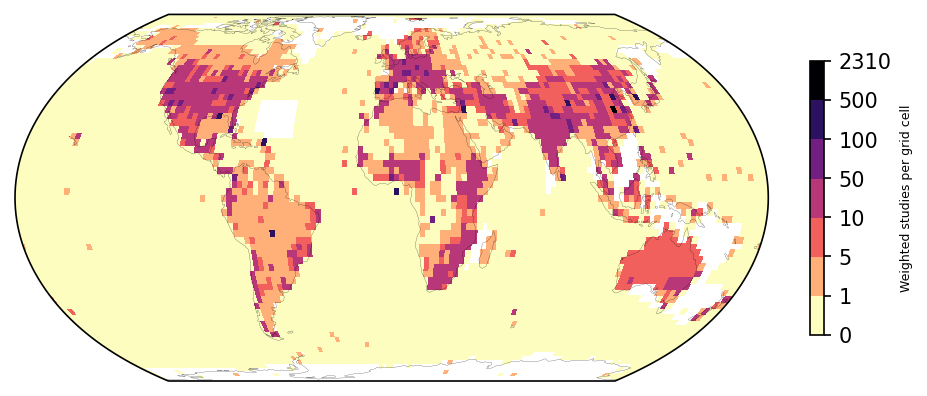

In [12]:
fig = plt.figure(dpi=150,figsize=(7.2,6.5))

gs = gridspec.GridSpec(4, 6, height_ratios=[.1, .25, 1, .25], bottom=.05, top=.95, wspace=.4, hspace=0.0)

ax = plt.subplot(gs[2, :], projection=ccrs.EqualEarth())

#ndf.loc[ndf['LON']>180,"LON"]-=360

n = np.array(ndf.precip_study_prop_lower).reshape(len(ndf.LAT.unique()), len(ndf.LON.unique()))
vm = n.max()
n[n==0] = np.nan

bounds = np.array([0,1,5,10,50,100,500,vm])

X, Y = np.meshgrid(
    list(ndf.LON.unique())+[ndf.LON.max()+2.5],   
    list(ndf.LAT.unique())+[ndf.LAT.max()+2.5], 
)
X.shape

ax.coastlines(lw=0.1)
mesh = ax.pcolormesh(
    X, Y,
    n,
    norm = mpl.colors.BoundaryNorm(bounds,256),
    #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
    #cmap = "YlOrBr",
    cmap = "magma_r",
    #cmap=plt.cm.get_cmap('YlOrBr',12), 
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)
cbar = plt.colorbar(mesh, orientation="vertical", fraction=0.05, pad=0.05, ax=ax, shrink=0.5)

cbar.set_label("Weighted studies per grid cell", fontsize=6)
#cbar.ax.tick_params(labelsize=6)

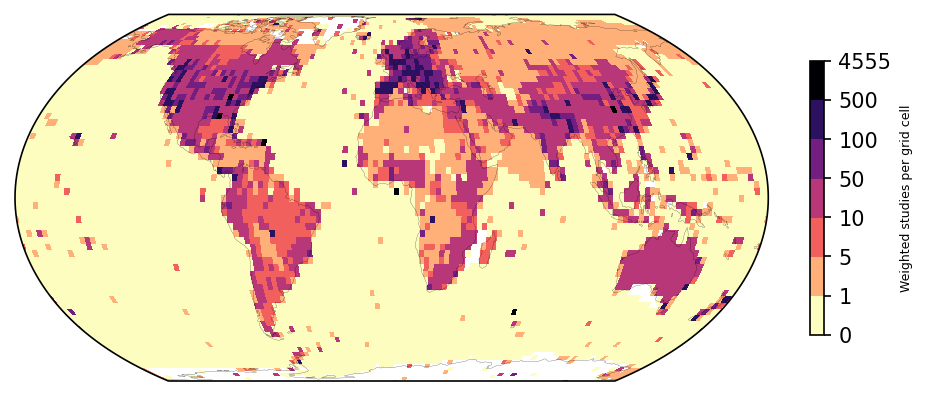

In [13]:
fig = plt.figure(dpi=150,figsize=(7.2,6.5))

gs = gridspec.GridSpec(4, 6, height_ratios=[.1, .25, 1, .25], bottom=.05, top=.95, wspace=.4, hspace=0.0)

ax = plt.subplot(gs[2, :], projection=ccrs.EqualEarth())

#ndf.loc[ndf['LON']>180,"LON"]-=360

n = np.array(ndf.temp_study_prop).reshape(len(ndf.LAT.unique()), len(ndf.LON.unique()))
vm = n.max()
n[n==0] = np.nan

bounds = np.array([0,1,5,10,50,100,500,vm])

X, Y = np.meshgrid(
    list(ndf.LON.unique())+[ndf.LON.max()+2.5],   
    list(ndf.LAT.unique())+[ndf.LAT.max()+2.5], 
)
X.shape

ax.coastlines(lw=0.1)
mesh = ax.pcolormesh(
    X, Y,
    n,
    norm = mpl.colors.BoundaryNorm(bounds,256),
    #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
    #cmap = "YlOrBr",
    cmap = "magma_r",
    #cmap=plt.cm.get_cmap('YlOrBr',12), 
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)
cbar = plt.colorbar(mesh, orientation="vertical", fraction=0.05, pad=0.05, ax=ax, shrink=0.5)

cbar.set_label("Weighted studies per grid cell", fontsize=6)
#cbar.ax.tick_params(labelsize=6)

In [14]:
ndf['precip_da_cat'] = abs(ndf['updated_precip']).fillna(0)
ndf['temp_da_cat'] = abs(ndf['updated_temp']).fillna(0)

ndf['temp_da_binary'] = np.where(abs(ndf['updated_temp']).isin([2,3]),1,0)
ndf['precip_da_binary'] = np.where(abs(ndf['updated_precip']).isin([2,3]),1,0)

ndf["n_da_impacts"] = ndf[['temp_da_binary','precip_da_binary']].sum(axis=1)

ndf["max_da_cat"] = np.max(ndf[['precip_da_cat','temp_da_cat']],axis=1)

In [15]:
ndf.loc[
    (ndf['precip_da_cat'].isin([2,3])) &
    (ndf['temp_da_cat'].isin([2,3])),
    "study_addition"
] = "add" 

ndf.loc[
    (~ndf['precip_da_cat'].isin([2,3])) &
    (~ndf['temp_da_cat'].isin([2,3])),
    "study_addition"
] = "add" 

ndf.loc[
    (ndf['precip_da_cat'].isin([2,3])) &
    (~ndf['temp_da_cat'].isin([2,3])),
    "study_addition" 
] = "precip" 

ndf.loc[
    (~ndf['precip_da_cat'].isin([2,3])) &
    (ndf['temp_da_cat'].isin([2,3])),
    "study_addition"  
] = "temp"

ndf.loc[ndf['study_addition']=="temp","total_study_prop"] = ndf.loc[ndf['study_addition']=="temp","temp_study_prop"]
ndf.loc[ndf['study_addition']=="precip","total_study_prop"] = ndf.loc[ndf['study_addition']=="precip","precip_study_prop"]
ndf.loc[ndf['study_addition']=="add","total_study_prop"] = ndf.loc[ndf['study_addition']=="add",["precip_study_prop","temp_study_prop"]].sum(axis=1)

print(ndf.groupby('study_addition').index.count())

ndf.head()

study_addition
add       5884
precip      56
temp      4428
Name: index, dtype: int64


,LAT,LON,LAT_25,LON_25,LAT_5,LON_5,knutson_precip,updated_precip,knutson_temp,updated_temp,...,precip_study_prop_upper,precip_study_prop_lower,precip_da_cat,temp_da_cat,temp_da_binary,precip_da_binary,n_da_impacts,max_da_cat,study_addition,total_study_prop
0,-88.75,-178.75,-88.75,-178.75,-87.5,-177.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0
1,-88.75,-176.25,-88.75,-176.25,-87.5,-177.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0,0,0,0.0,add,1.0
2,-88.75,-173.75,-88.75,-173.75,-87.5,-172.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0
3,-88.75,-171.25,-88.75,-171.25,-87.5,-172.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0
4,-88.75,-168.75,-88.75,-168.75,-87.5,-167.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0


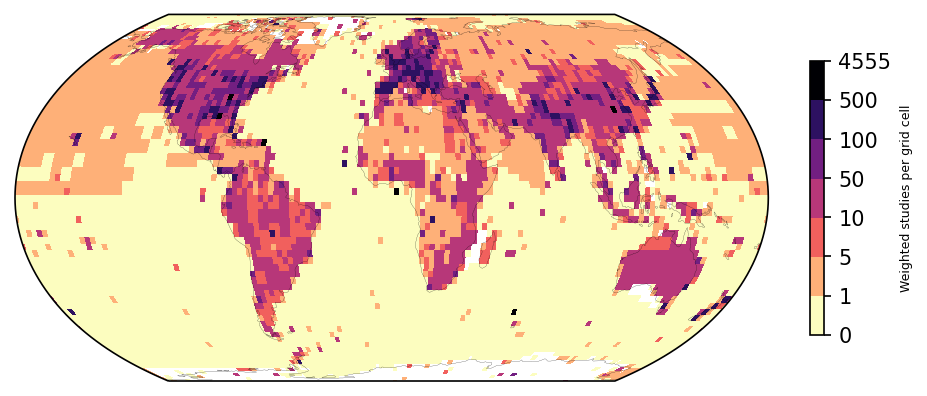

In [16]:
fig = plt.figure(dpi=150,figsize=(7.2,6.5))

gs = gridspec.GridSpec(4, 6, height_ratios=[.1, .25, 1, .25], bottom=.05, top=.95, wspace=.4, hspace=0.0)

ax = plt.subplot(gs[2, :], projection=ccrs.EqualEarth())

#ndf.loc[ndf['LON']>180,"LON"]-=360

n = np.array(ndf.total_study_prop).reshape(len(ndf.LAT.unique()), len(ndf.LON.unique()))
vm = n.max()
n[n==0] = np.nan

bounds = np.array([0,1,5,10,50,100,500,vm])

X, Y = np.meshgrid(
    list(ndf.LON.unique())+[ndf.LON.max()+2.5],   
    list(ndf.LAT.unique())+[ndf.LAT.max()+2.5], 
)
X.shape

ax.coastlines(lw=0.1)
mesh = ax.pcolormesh(
    X, Y,
    n,
    norm = mpl.colors.BoundaryNorm(bounds,256),
    #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
    #cmap = "YlOrBr",
    cmap = "magma_r",
    #cmap=plt.cm.get_cmap('YlOrBr',12), 
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)
cbar = plt.colorbar(mesh, orientation="vertical", fraction=0.05, pad=0.05, ax=ax, shrink=0.5)

cbar.set_label("Weighted studies per grid cell", fontsize=6)
#cbar.ax.tick_params(labelsize=6)

In [17]:
import math
def area_cell(lat, lon, degrees): 
    # calculate the area of a gridcell given the center lat and lon and the size in degrees
    if lon <0:
        lon+=360
    R = 6371
    f0 = math.radians(lat-degrees*0.5)
    f1 = math.radians(lat+degrees*0.5)
    l0 = math.radians(lon-degrees*0.5)
    l1 = math.radians(lon+degrees*0.5)

    return (math.sin(f1)-math.sin(f0)) * (l1 - l0) * R**2


ndf['area'] = ndf.apply(lambda x: area_cell(x['LAT'], x['LON'], 2.5), axis=1)
ndf.head()

,LAT,LON,LAT_25,LON_25,LAT_5,LON_5,knutson_precip,updated_precip,knutson_temp,updated_temp,...,precip_study_prop_lower,precip_da_cat,temp_da_cat,temp_da_binary,precip_da_binary,n_da_impacts,max_da_cat,study_addition,total_study_prop,area
0,-88.75,-178.75,-88.75,-178.75,-87.5,-177.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015
1,-88.75,-176.25,-88.75,-176.25,-87.5,-177.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0,0,0,0.0,add,1.0,1685.654015
2,-88.75,-173.75,-88.75,-173.75,-87.5,-172.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015
3,-88.75,-171.25,-88.75,-171.25,-87.5,-172.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015
4,-88.75,-168.75,-88.75,-168.75,-87.5,-167.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015


In [18]:
ndf['is_land'] = globe.is_land(ndf.LAT+1.25, ndf.LON+1.25)

In [19]:
ndf.to_csv('../data/2_merged_da_data.csv', index=False)
ndf.head()

,LAT,LON,LAT_25,LON_25,LAT_5,LON_5,knutson_precip,updated_precip,knutson_temp,updated_temp,...,precip_da_cat,temp_da_cat,temp_da_binary,precip_da_binary,n_da_impacts,max_da_cat,study_addition,total_study_prop,area,is_land
0,-88.75,-178.75,-88.75,-178.75,-87.5,-177.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015,True
1,-88.75,-176.25,-88.75,-176.25,-87.5,-177.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,add,1.0,1685.654015,True
2,-88.75,-173.75,-88.75,-173.75,-87.5,-172.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015,True
3,-88.75,-171.25,-88.75,-171.25,-87.5,-172.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015,True
4,-88.75,-168.75,-88.75,-168.75,-87.5,-167.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015,True


In [20]:
df_ndf

,ndf_id,doc_id,gridcells,weight
0,7674.0,3323227.0,6,0.166667
1,6804.0,3323227.0,6,0.166667
2,6720.0,3323227.0,6,0.166667
3,7327.0,3323227.0,6,0.166667
4,7674.0,3323227.0,6,0.166667
...,...,...,...,...
5447189,7240.0,3986956.0,4,0.250000
5447190,7872.0,3986956.0,4,0.250000
5447191,7305.0,3986956.0,4,0.250000
5447192,7029.0,3986966.0,2,0.500000


In [21]:
precip_studies = driver_df[driver_df['6 - Precipitation - upper_pred']>=0.5].id
print(precip_studies.shape[0])

def sum_gridcells(row):
    n_gridcells = row.shape[0]
    n_trend = row[abs(row).isin([2,3])].shape[0]
    na_cells = row[pd.isna(row)].shape[0]
    da_trend_cells = n_trend/n_gridcells
    
    return pd.Series([n_gridcells, n_trend, na_cells, da_trend_cells], index=["gridcells",'da_trend','na_cells','da_trend_prop'])

precip_df = (
    df_ndf[df_ndf['doc_id'].isin(precip_studies)]
    .merge(ndf[['index','updated_precip']],left_on="ndf_id",right_on="index")
    .groupby(['doc_id'])['updated_precip']
    .apply(sum_gridcells)
    .reset_index()
    .pivot(index="doc_id",columns="level_1")
).reset_index()
precip_df.columns = ["id","precip_trend_cells",'precip_da_prop',"gridcells","precip_na_cells",]
precip_df['precip_driver'] = 1
precip_df = precip_df.merge(driver_df[['id','6 - Precipitation - upper_pred','6 - Precipitation - mean_prediction','6 - Precipitation - lower_pred']])
print(precip_df.shape)
#precip_
precip_df.head()

56835
(44571, 9)


,id,precip_trend_cells,precip_da_prop,gridcells,precip_na_cells,precip_driver,6 - Precipitation - upper_pred,6 - Precipitation - mean_prediction,6 - Precipitation - lower_pred
0,110.0,3.0,0.375,8.0,1.0,1,0.844943,0.697851,0.550758
1,266.0,0.0,0.000,1.0,0.0,1,0.764484,0.636945,0.509405
2,466.0,0.0,0.000,2.0,1.0,1,0.694265,0.552738,0.411211
3,491.0,0.0,0.000,1.0,1.0,1,0.826951,0.647819,0.468688
4,514.0,0.0,0.000,1.0,0.0,1,0.871765,0.791932,0.712099


In [22]:
temp_studies = driver_df[driver_df['6 - Temperature - upper_pred']>=0.5].id

temp_df = (
    df_ndf[df_ndf['doc_id'].isin(temp_studies)]
    .merge(ndf[['index','updated_temp']],left_on="ndf_id",right_on="index")
    .groupby(['doc_id'])['updated_temp']
    .apply(sum_gridcells)
    .reset_index()
    .pivot(index="doc_id",columns="level_1")
).reset_index()
temp_df.columns = ["id","temp_trend_cells",'temp_da_prop',"gridcells","temp_na_cells",]
temp_df['temp_driver'] = 1
print(temp_df.shape)
temp_df = temp_df.merge(driver_df[['id','6 - Temperature - upper_pred','6 - Temperature - mean_prediction','6 - Temperature - lower_pred']])
temp_df.head()

(86299, 6)


,id,temp_trend_cells,temp_da_prop,gridcells,temp_na_cells,temp_driver,6 - Temperature - upper_pred,6 - Temperature - mean_prediction,6 - Temperature - lower_pred
0,48.0,1.0,1.000000,1.0,0.0,1,0.537484,0.428129,0.318774
1,110.0,8.0,1.000000,8.0,0.0,1,0.928111,0.898859,0.869607
2,160.0,2.0,1.000000,2.0,0.0,1,0.504505,0.374439,0.244373
3,189.0,359.0,0.712302,504.0,0.0,1,0.891340,0.839745,0.788149
4,254.0,12.0,1.000000,12.0,0.0,1,0.921118,0.740390,0.559662


In [23]:
temp_df[temp_df['id']==3785865.0]

,id,temp_trend_cells,temp_da_prop,gridcells,temp_na_cells,temp_driver,6 - Temperature - upper_pred,6 - Temperature - mean_prediction,6 - Temperature - lower_pred


In [24]:
df_da = temp_df.merge(precip_df, how="outer")
print(df_da.shape)

df_da.to_csv('../data/study_da.csv',index=False)
df_da.head()

(98748, 16)


,id,temp_trend_cells,temp_da_prop,gridcells,temp_na_cells,temp_driver,6 - Temperature - upper_pred,6 - Temperature - mean_prediction,6 - Temperature - lower_pred,precip_trend_cells,precip_da_prop,precip_na_cells,precip_driver,6 - Precipitation - upper_pred,6 - Precipitation - mean_prediction,6 - Precipitation - lower_pred
0,48.0,1.0,1.000000,1.0,0.0,1.0,0.537484,0.428129,0.318774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,110.0,8.0,1.000000,8.0,0.0,1.0,0.928111,0.898859,0.869607,3.0,0.375,1.0,1.0,0.844943,0.697851,0.550758
2,160.0,2.0,1.000000,2.0,0.0,1.0,0.504505,0.374439,0.244373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,189.0,359.0,0.712302,504.0,0.0,1.0,0.891340,0.839745,0.788149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,254.0,12.0,1.000000,12.0,0.0,1.0,0.921118,0.740390,0.559662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
